In [3]:
%matplotlib inline

import numpy as np
import random
from astropy.table import Table
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits
import healpy as hp
from scipy.interpolate import interp1d

from main_def import cut, flux_to_mag
from main_def_2 import relative_density_plot, circular_mask_radii_func, search_around, make_cutout_table
from main_def_2 import overdensity, extract_annulus, flux_to_mag, get_mag_decals, scatter_plot
from main_def_2 import make_plot_zoom, make_plot_zoom_comp

from kdcount import KDTree
from veto import veto, veto_ellip, match

from astropy import units as u

In [4]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

## Loading catalogues and applying conditions

In [5]:
#Loading BGS catalogue for 1400 s.q.d footprint with Quality Cuts (QCs) applied (cat) and without QCs (catr)
catr = Table.read('caseC/catr.fits')
cat = Table.read('caseC/cat.fits')

In [4]:
#Loading the Legacy Survey Large Galaxy Atlas (href: https://github.com/moustakas/LSLGA)
LSLGA = Table.read('LSLGA-v2.0.fits')

In [5]:
#Loading TWOMASS Bright Extended Sources catalogue
twomass = Table.read('asu.fits')
#Renaming RA and DEC coluns for simplicity
twomass['RA'] = twomass['RAJ2000']
twomass['DEC'] = twomass['DEJ2000']
twomass.remove_column('RAJ2000')
twomass.remove_column('DEJ2000')

In [6]:
#Loading Tycho2 catalogue
tycho = Table.read('tycho2.fits')

In [7]:
#Reducing footprint of catalogues to match the BGS footprint of 1400 s.q.d plus delta for each side

delta = 240/3600.
print(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, catr['DEC'].max()+delta)

twomass_S = cut(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, 
                catr['DEC'].max()+delta, twomass)

LSLGA_S = cut(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, 
                catr['DEC'].max()+delta, LSLGA)

tycho_S = cut(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, 
                catr['DEC'].max()+delta, tycho)

159.933333538 230.066643383 -2.06665833528 18.0666573929


## RANDOMS

In [6]:
#ran = '/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/randoms-dr7.1-0.22.0-1.fits'

#random_S = cut(catr['RA'].min(), catr['RA'].max(), catr['DEC'].min(), catr['DEC'].max(), random)
#random_S.write('caseC/random_1400.fits', overwrite=True)

ran = 'caseC/random_1400.fits'
ran = Table.read(ran)

## TWOMASS and LSLGA VETO

In [9]:
#TWOMASS radii
twomass_radii = [[9.5,100], [10.5, 80], [11.5, 70], [12.5, 50], [13.5, 30], 
                 [14.5, 20], [15.5, 10], [16.5, 5]]

#LSLGA radii
LSLGA_radii = [[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], 
               [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]]

In [10]:
def mask_funct(twomass_radii, LSLGA_radii):
    
    x1, y1 = np.transpose(twomass_radii)
    circular_mask_radii_func1 = interp1d(x1, y1, bounds_error=False, fill_value=(y1[0], y1[-1]))
    
    x2, y2 = np.transpose(LSLGA_radii)
    circular_mask_radii_func2 = interp1d(x2, y2, bounds_error=False, fill_value=(y2[0], y2[-1]))
    
    plt.figure(figsize=(10,6))
    
    mag = np.linspace(5, 20, 30)
    
    plt.plot(mag, circular_mask_radii_func1(mag), marker='o', label=r'TWOMASS(J_ext)')
    plt.plot(mag, circular_mask_radii_func2(mag), marker='o', label=r'LSLGA(MAG)')
    plt.title(r'Mask radii')
    plt.legend()
    plt.grid()
    plt.xlabel(r'mag')
    plt.ylabel(r'r(arcsec)')
    plt.show()
    

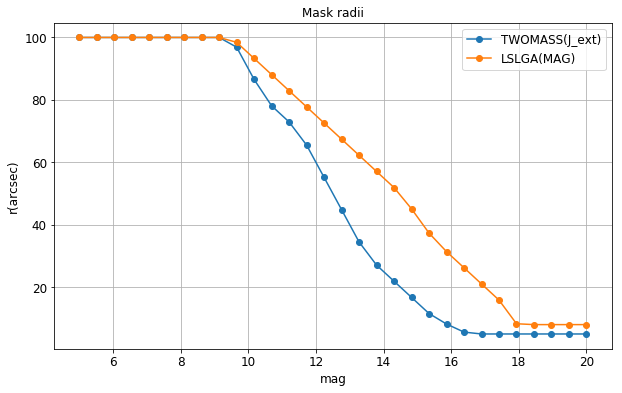

In [11]:
mask_funct(twomass_radii, LSLGA_radii)

In [12]:
def twomass_fit(twomass, radii):
    
    x, y = np.transpose(radii)
    circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))
    j_ext = np.array(twomass['J_ext'])
    major = circular_mask_radii_func(j_ext)/3600.#[degrees]
    minor = major*twomass['Jb_a']#[degrees]
    angle = -twomass['Jpa'] - 90.
    
    return twomass['RA'], twomass['DEC'], major, minor, angle

In [13]:
def LSLGA_fit(LSLGA, radii):
    
    x, y = np.transpose(radii)
    circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))
    MAG = np.array(LSLGA['MAG'])
    major = circular_mask_radii_func(MAG)/3600.#[degrees]
    minor = major*LSLGA['BA']#[degrees]
    angle = 90 - LSLGA['PA'] #-LSLGA['PA'] - 90.
    
    return LSLGA['RA'], LSLGA['DEC'], major, minor, angle

In [14]:
def twomass_veto(cat, twomass):
    
    RA, DEC, major, minor, angle = twomass_fit(twomass, twomass_radii)
    centers = (RA, DEC)
    mask = veto_ellip((cat['RA'], cat['DEC']), centers, major, minor, angle)
    #dataset[vetoname][mask] = True
    
    return mask

In [15]:
def LSLGA_veto(cat, LSLGA):
    
    RA, DEC, major, minor, angle = LSLGA_fit(LSLGA,LSLGA_radii)
    centers = (RA, DEC)
    mask = veto_ellip((cat['RA'], cat['DEC']), centers, major, minor, angle)
    #dataset[vetoname][mask] = True
    
    return mask

In [16]:
mask = twomass_S['J_ext'] < 14
#np.sum(mask)
twomass_mask_catr = twomass_veto(catr, twomass_S[mask])
twomass_mask_cat = twomass_veto(cat, twomass_S[mask])

In [17]:
mask2 = LSLGA_S['MAG'] < 17
#np.sum(mask2)
LSLGA_mask_catr = LSLGA_veto(catr, LSLGA_S[mask2])
LSLGA_mask_cat = LSLGA_veto(cat, LSLGA_S[mask2])

In [18]:
#mask_R = LSLGA_S['MAG'] < 17
#np.sum(mask2)
twomass_mask_ran = twomass_veto(ran, twomass_S[mask])
LSLGA_mask_ran = LSLGA_veto(ran, LSLGA_S[mask2])

In [20]:
def make_plot_zoom_comp(cat, BGAL1, BGAL2, veto1, veto2, ra, dec, m):
    """
    Produces the ellipses of a specific galaxy (if exists)for two different vetoes: TWOMASS and LSLGA.

    Keyword arguments:

    """
    from matplotlib.patches import Ellipse

    RA1, DEC1, major1, minor1, angle1 = twomass_fit(BGAL1, twomass_radii)
    l01 = BGAL1['Jpa']
    j_ext1 = BGAL1['J_ext']

    RA2, DEC2, major2, minor2, angle2 = LSLGA_fit(BGAL2, LSLGA_radii)
    l02 = BGAL2['PA']
    j_ext2 = BGAL2['MAG']

    #vetoes in common
    x = cat['RA'][(veto1) & (veto2)]
    y = cat['DEC'][(veto1) & (veto2)]

    h1 = RA1
    z1 = DEC1

    h2 = RA2
    z2 = DEC2

    index1 = min(range(len(h1)), key=lambda i: abs(h1[i]-ra))
    index2 = min(range(len(h2)), key=lambda i: abs(h2[i]-ra))
    plt.figure(figsize=(10,10))
    plt.scatter(x, y, marker='.', color='orange')
    plt.scatter(cat['RA'][(~veto1) & (~veto2)], cat['DEC'][(~veto1) & (~veto2)], marker='.', color='g')
    plt.scatter(cat['RA'][(~veto1) & (veto2)], cat['DEC'][(~veto1) & (veto2)], marker='.', color='blue')
    plt.scatter(cat['RA'][(veto1) & (~veto2)], cat['DEC'][(veto1) & (~veto2)], marker='.', color='blue')
    plt.scatter(h1, z1, marker='*', color='r')
    plt.scatter(h2, z2, marker='+', color='black')

    print('TWOMASS: RA = %2.5g, DEC = %2.5g, J_{ext}=%2.5g, angle = %d'%(h1[index1], z1[index1],
                                                                          j_ext1[index1], l01[index1]))
    print('LSLGA: RA = %2.5g, DEC = %2.5g, MAG=%2.5g, angle = %d'%(h2[index2], z2[index2],
                                                                    j_ext2[index2], l02[index2]))
    #print(title1)
    #print(title2)
    plt.xlim(ra-m*major1[index1], ra+m*major1[index1])
    plt.ylim(dec-m*major1[index1], dec+m*major1[index1])

    ax = plt.gca()
    ellipse1 = Ellipse((h1[index1], z1[index1]), width=2*major1[index1], height=2*minor1[index1], angle=angle1[index1],
                       edgecolor='r', fc='None', lw=1)

    ellipse2 = Ellipse((h2[index2], z2[index2]), width=2*major2[index2], height=2*minor2[index2], angle=angle2[index2],
                       edgecolor='r', fc='None', lw=1, ls='--')
    #ellipse3 = Ellipse((h[index], z[index]), width=2*a_best_fit[index], height=2*b_best_fit[index], angle=l[index], edgecolor='black', fc='None', lw=1)
    #ellipse2 = Ellipse((h[index], z[index]), width=2*a_r_fe[index], height=2*b_r_fe[index], angle=l[index], edgecolor='blue', fc='None', lw=1)

    ax.add_patch(ellipse1)
    ax.add_patch(ellipse2)
    #ax.add_patch(ellipse3)
    ax.legend([r'TWOMASS: $a =%2.4g\,(arcsec)$'%(major1[index1]*3600), r'LSLGA: $a =%2.4g\,(arcsec)$'%(major2[index2]*3600)], loc = 'upper right')
    ax.invert_xaxis()
    plt.show()

In [19]:
#mask_RA = np.logical_and(cat['RA'] > 180, cat['RA'] < 186.33)
#mask_DEC = np.logical_and(cat['DEC'] > 5, cat['DEC'] < 12.95)
#cat[(~twomass_mask_cat) & (~LSLGA_mask_cat) & (mask_RA) & (mask_DEC)]

TWOMASS: RA = 186.27, DEC = 12.887, J_{ext}=7.124, angle = -32
LSLGA: RA = 186.27, DEC = 12.887, MAG=10.011, angle = 133


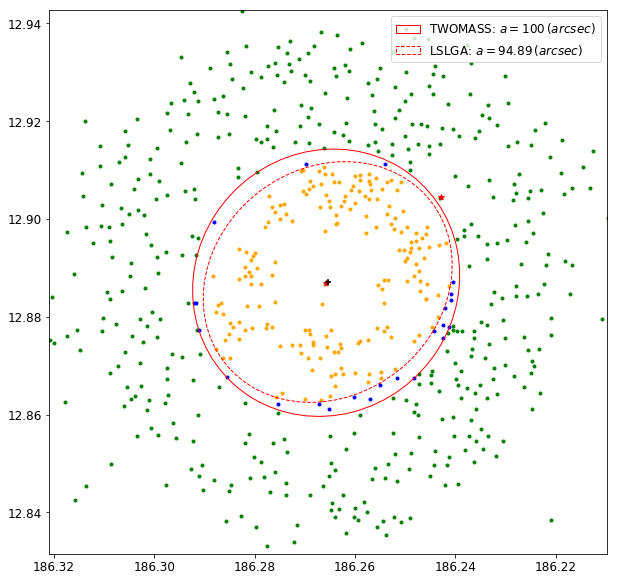

In [21]:
make_plot_zoom_comp(catr, twomass_S[mask], LSLGA_S[mask2], twomass_mask_catr,
                    LSLGA_mask_catr, 186.26544, 12.8871094, 2)

TWOMASS: RA = 186.27, DEC = 12.887, J_{ext}=7.124, angle = -32
LSLGA: RA = 186.27, DEC = 12.887, MAG=10.011, angle = 133


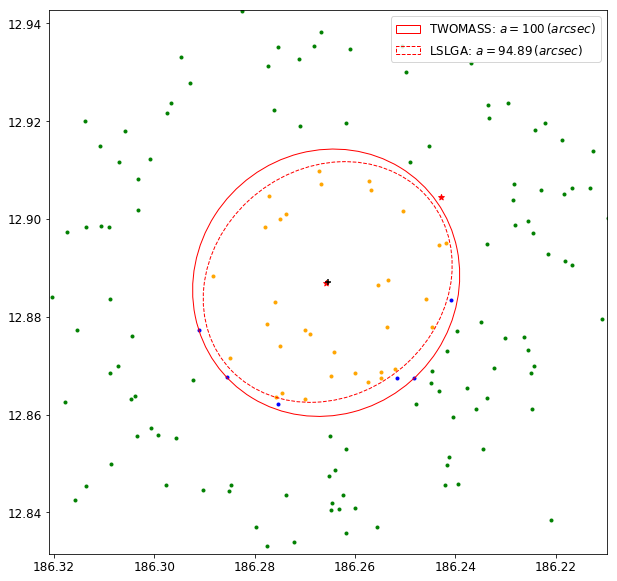

In [22]:
make_plot_zoom_comp(cat, twomass_S[mask], LSLGA_S[mask2], twomass_mask_cat, 
                    LSLGA_mask_cat, 186.26544, 12.8871094, 2)

pixels: 1527


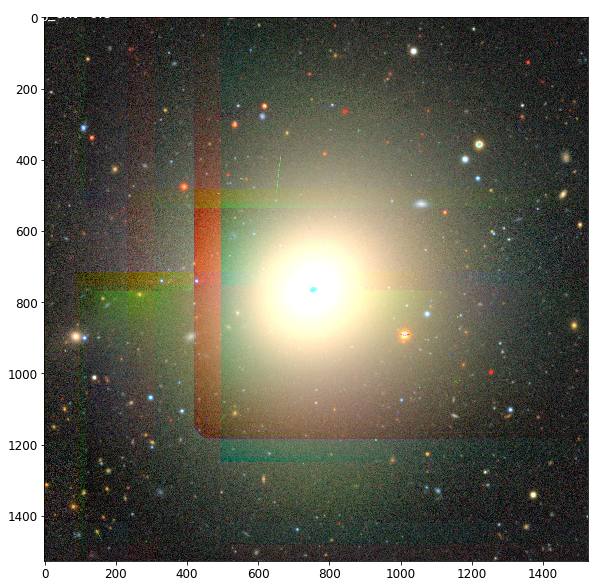

In [23]:
make_cutout_table(186.26544, 12.8871094, 6.83, 'J_ext', (1,1), False, boxsize=400, layer='decals-dr7', layer2=None)

TWOMASS: RA = 191.29, DEC = -0.46191, J_{ext}=8.195, angle = 42
LSLGA: RA = 191.29, DEC = -0.46188, MAG=11.455, angle = 40


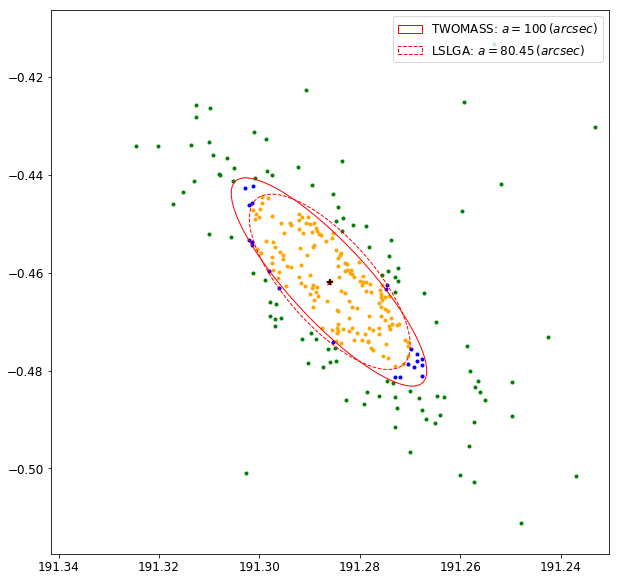

In [30]:
make_plot_zoom_comp(catr, twomass_S[mask], LSLGA_S[mask2], twomass_mask_catr, LSLGA_mask_catr, 191.286, -0.46191, 2)

## 2D density plots

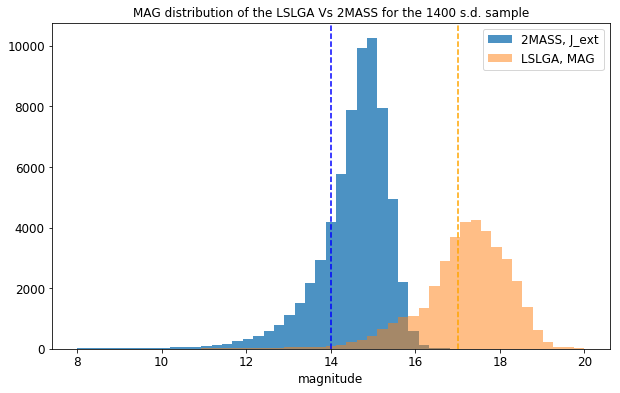

In [24]:
bins = np.linspace(8, 20, 50)
plt.figure(figsize=(10,6))
plt.hist(twomass_S['J_ext'], bins=bins, alpha=0.8, label=r'2MASS, J_ext')
plt.hist(LSLGA_S['MAG'], bins=bins, alpha=0.5, label=r'LSLGA, MAG')
plt.xlabel(r'magnitude')
plt.title(r'MAG distribution of the LSLGA Vs 2MASS for the 1400 s.d. sample')
plt.axvline(14, c='blue', ls='--')
plt.axvline(17, c='orange', ls='--')
plt.legend()
plt.show()

J_ext < 8.00
35846 nearby objects ~ 1.55549 %
69 sources ~0.106585 % 


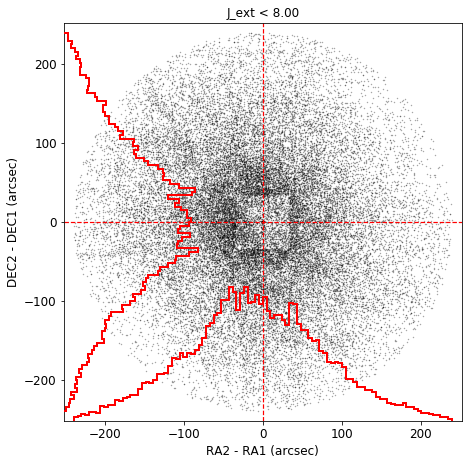

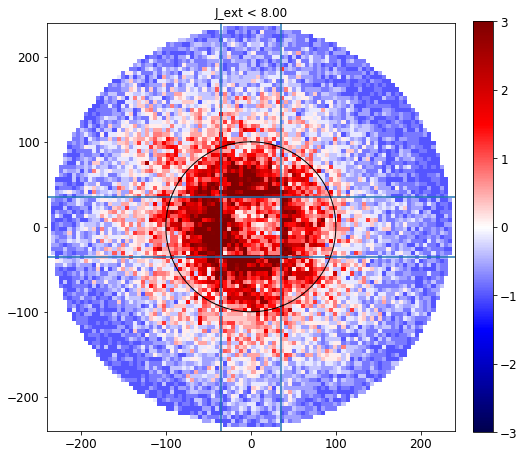

8.00 < J_ext < 10.00
23119 nearby objects ~ 1.00322 %
148 sources ~0.228617 % 


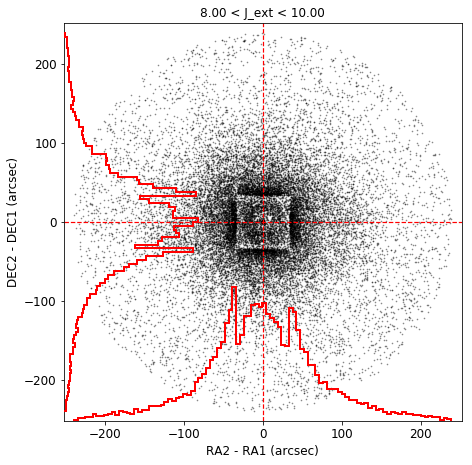

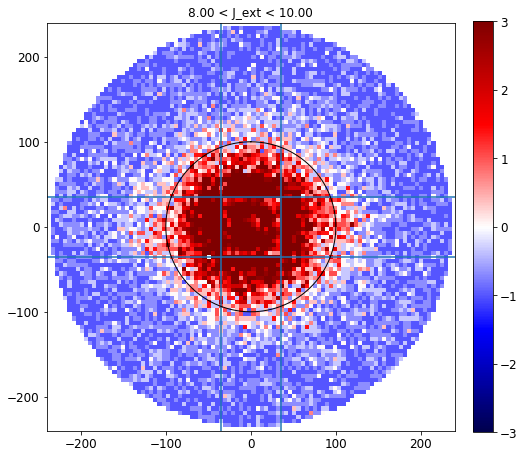

10.00 < J_ext < 12.00
44626 nearby objects ~ 1.93648 %
928 sources ~1.43349 % 


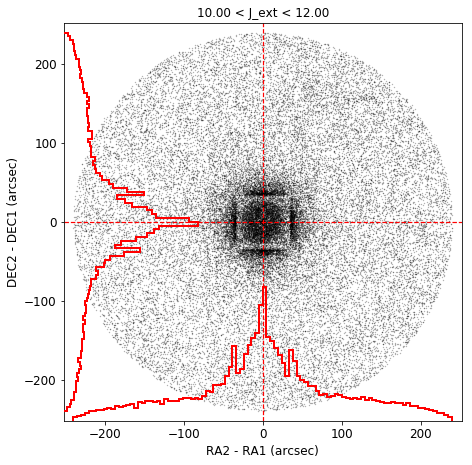

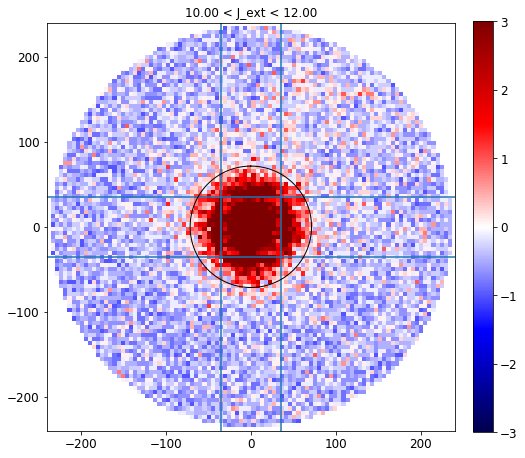

12.00 < J_ext < 14.00
366097 nearby objects ~ 15.8863 %
11603 sources ~17.9233 % 


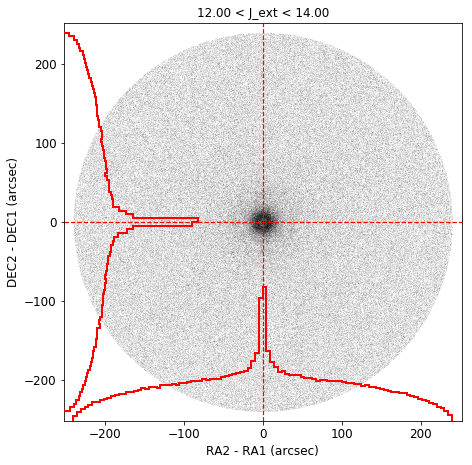

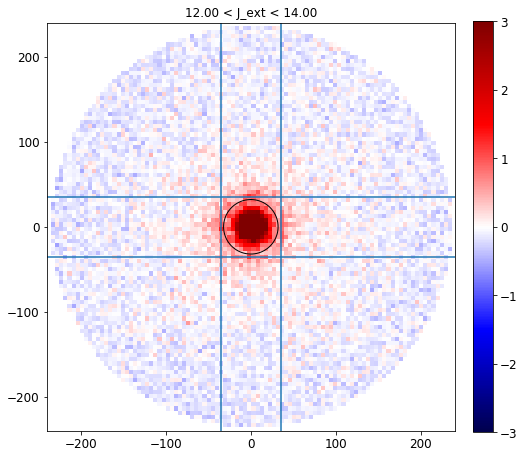

14.00 < J_ext < 16.00
1539048 nearby objects ~ 66.7849 %
51675 sources ~79.823 % 


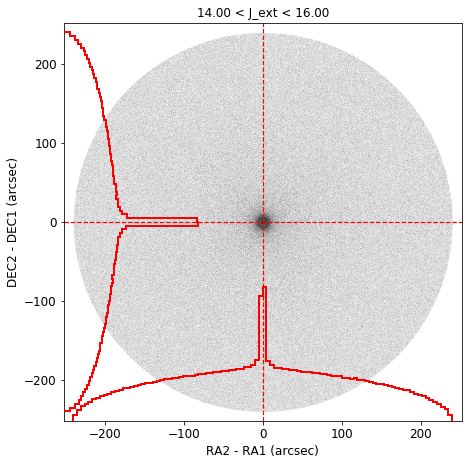

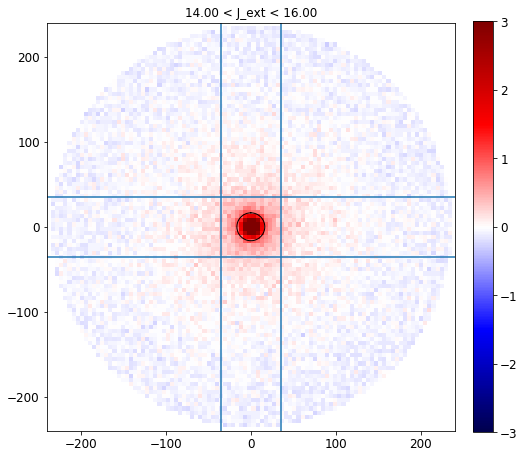

J_ext < 8.00
8468 nearby objects ~ 0.416359 %
69 sources ~0.106585 % 


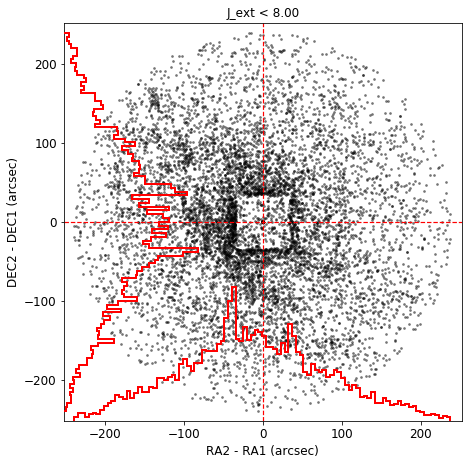

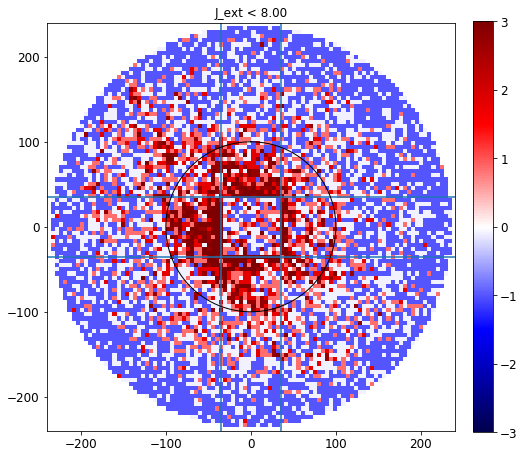

8.00 < J_ext < 10.00
7336 nearby objects ~ 0.3607 %
148 sources ~0.228617 % 


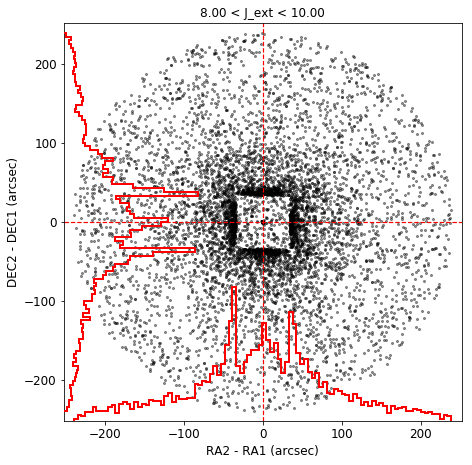

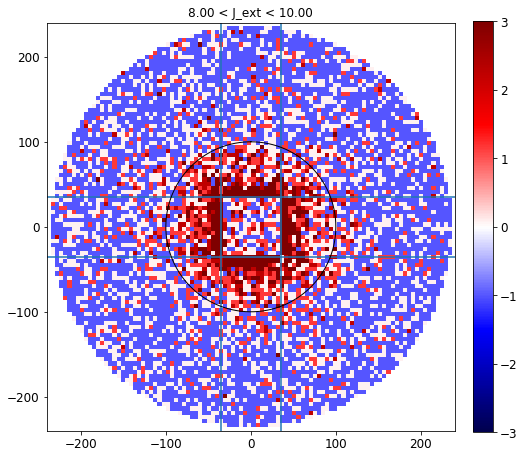

10.00 < J_ext < 12.00
28386 nearby objects ~ 1.3957 %
928 sources ~1.43349 % 


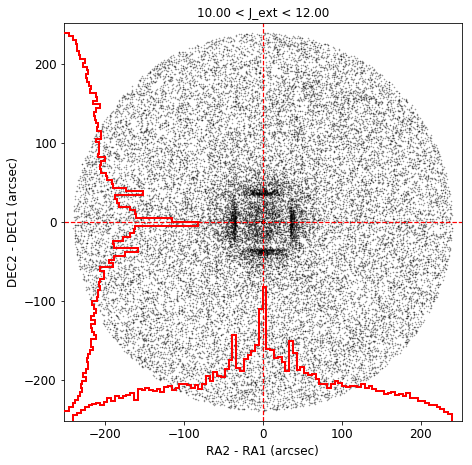

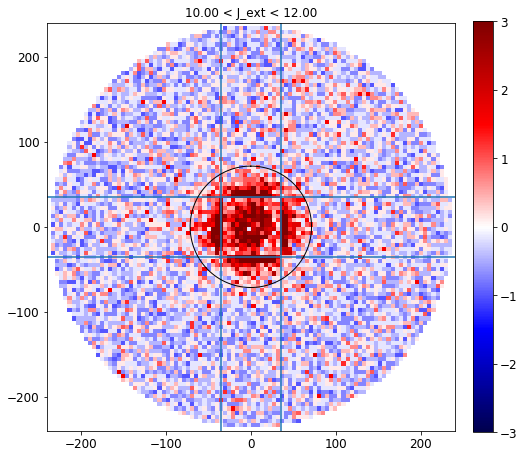

12.00 < J_ext < 14.00
315839 nearby objects ~ 15.5293 %
11603 sources ~17.9233 % 


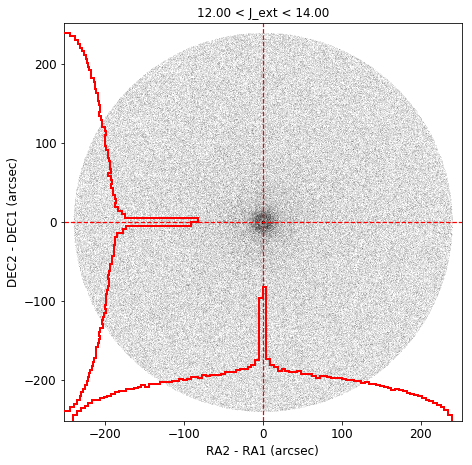

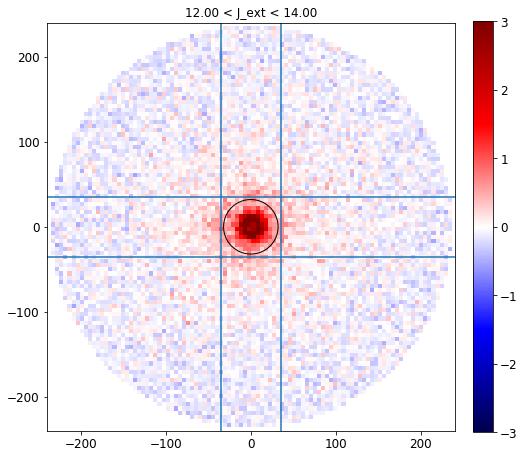

14.00 < J_ext < 16.00
1374660 nearby objects ~ 67.59 %
51675 sources ~79.823 % 


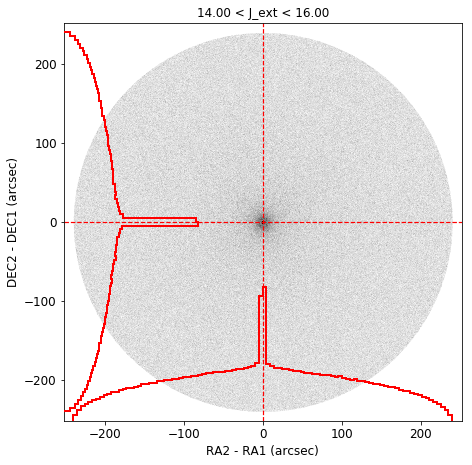

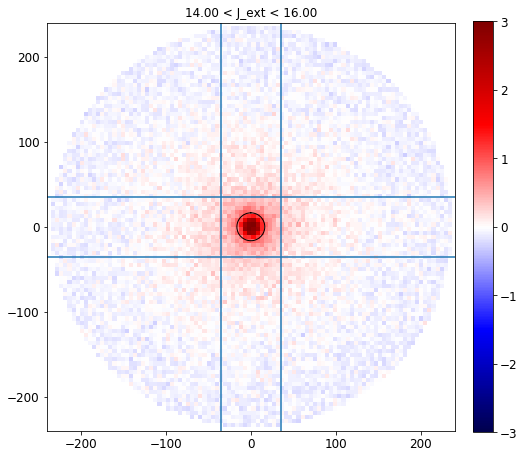

J_ext < 8.00
5298 nearby objects ~ 0.264667 %
69 sources ~0.106585 % 


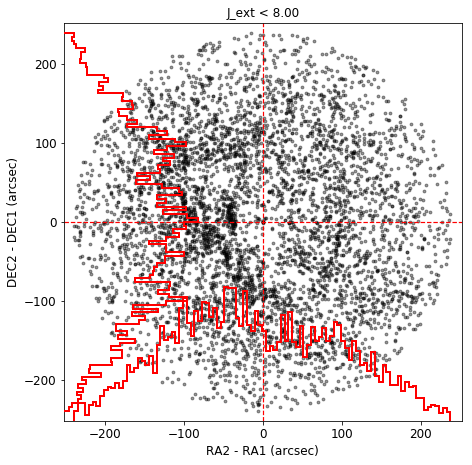

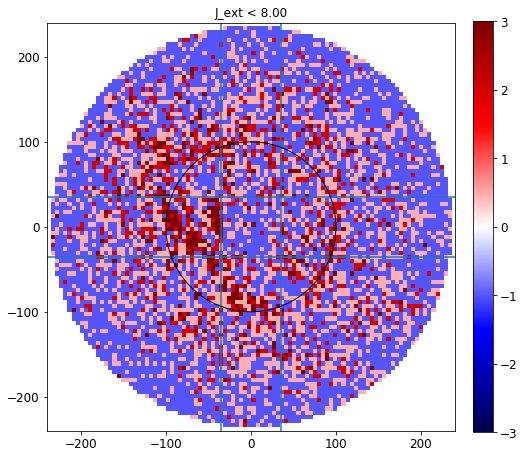

8.00 < J_ext < 10.00
4022 nearby objects ~ 0.200923 %
148 sources ~0.228617 % 


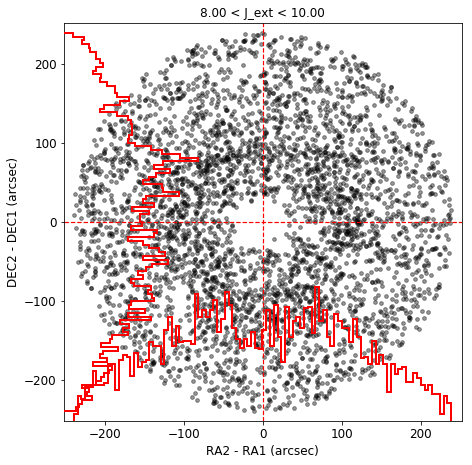

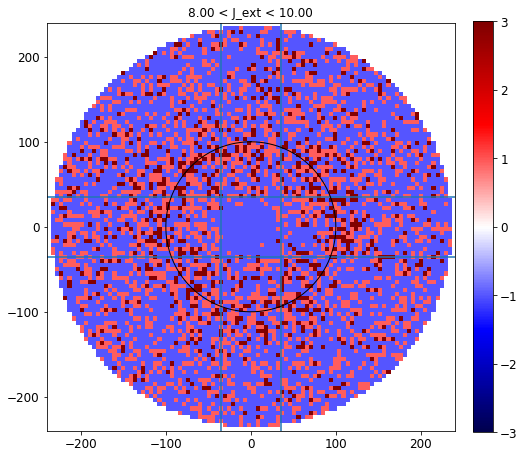

10.00 < J_ext < 12.00
20743 nearby objects ~ 1.03624 %
928 sources ~1.43349 % 


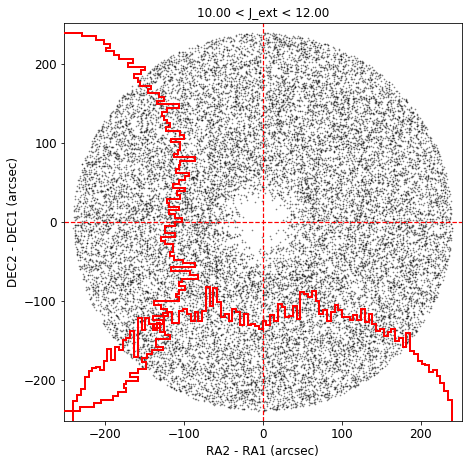

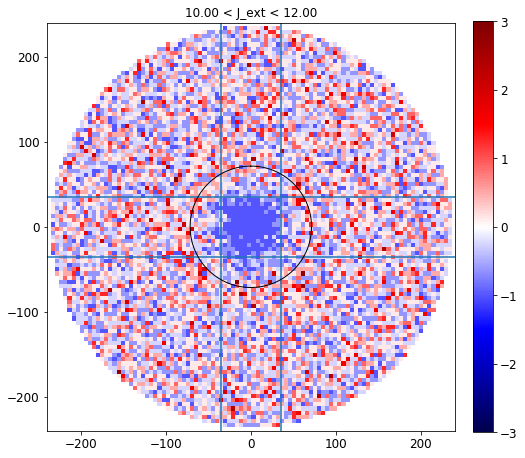

12.00 < J_ext < 14.00
281516 nearby objects ~ 14.0634 %
11603 sources ~17.9233 % 


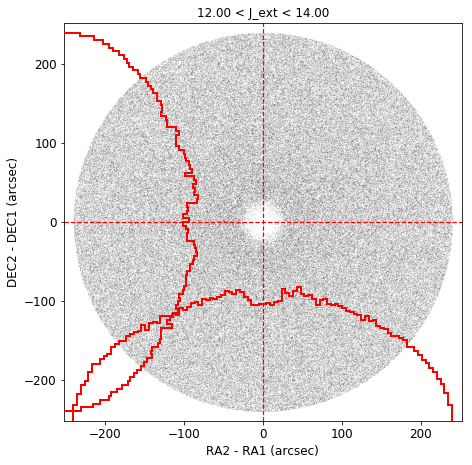

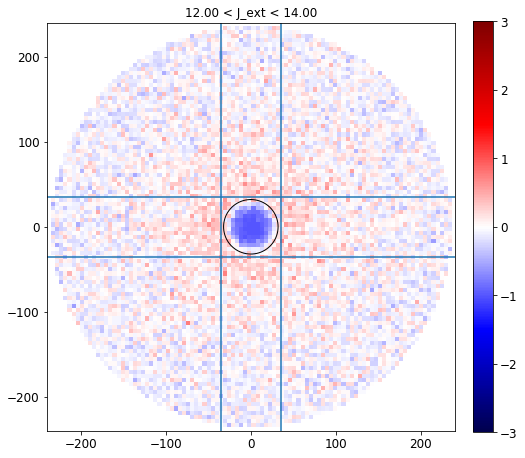

14.00 < J_ext < 16.00
1342526 nearby objects ~ 67.0672 %
51675 sources ~79.823 % 


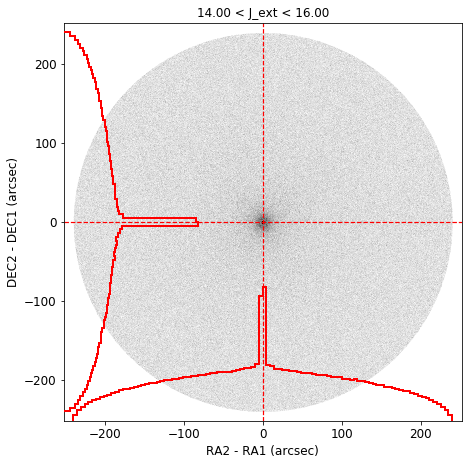

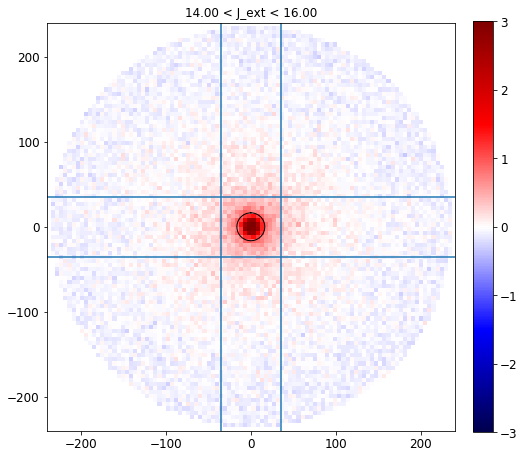

In [25]:
den_twomass_catr = overdensity(catr, twomass_S, 'J_ext', 35, density=False, magbins=(8,16,5))
den_twomass_cat = overdensity(cat, twomass_S, 'J_ext', 35, density=False, magbins=(8,16,5))
den_twomass_cat_twomass = overdensity(cat[~twomass_mask_cat], twomass_S, 'J_ext', 35, density=False, magbins=(8,16,5))
#den_LSLGA_cat = overdensity(cat, LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))
#den_LSLGA_catr = overdensity(catr, LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))
#den_LSLGA_cat_LSLGA = overdensity(cat[~LSLGA_mask_cat], LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))

5351097 nearby objects ~ 38.7968 %


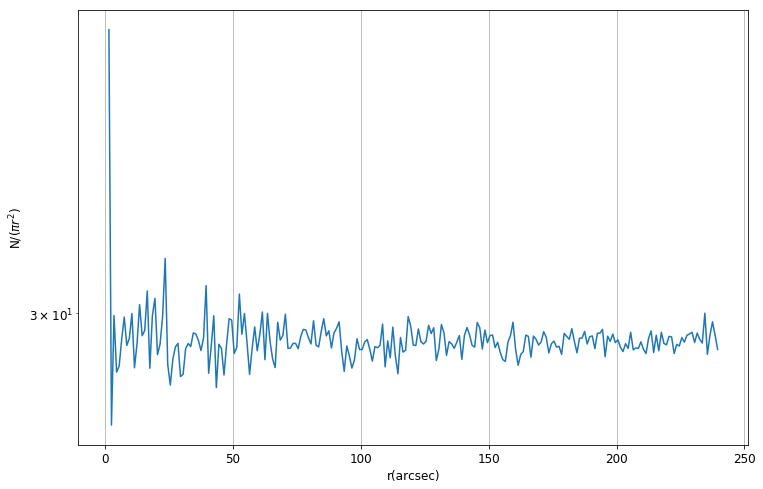

In [46]:
den_twomass_ran = overdensity(ran, twomass_S, 'J_ext', 35, density=False, magbins=(8,16,5))
#den_LSLGA_ran = overdensity(ran, LSLGA_S, 'J_ext', 35, density=True, magbins=(8,16,5))

## POSTAGE IMAGES

27541 nearby objects ~ 1.37584 %
1110 sources ~1.71463 % 
Inside shell: 2501


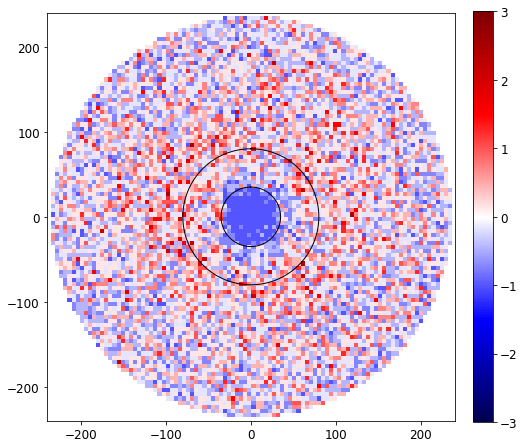

In [28]:
#a,b,c = extract_annulus(cat[~LSLGA_mask_cat], LSLGA_S, 'MAG', plot2d='square', mag=(12,15), annulus=(35,45))
a,b,c = extract_annulus(cat[~twomass_mask_cat], twomass_S, 'J_ext', plot2d='circle', mag=(0,12), annulus=(35,80))
#a,b,c = extract_annulus(cat[(twomass_mask_cat) & (~LSLGA_mask_cat)], twomass_S, 'J_ext', plot2d='circle', mag=(0,14), annulus=(5,40))
#a,b,c = extract_annulus(cat[(~twomass_mask_cat) & (LSLGA_mask_cat)], LSLGA_S, 'MAG', plot2d='circle', mag=(0,17), annulus=(5,30))

6789 nearby objects ~ 0.339151 %
181 sources ~0.279593 % 
Inside shell: 773


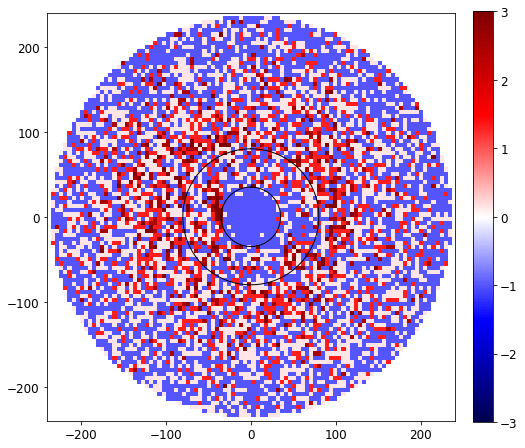

pixels: 76
pixels: 76


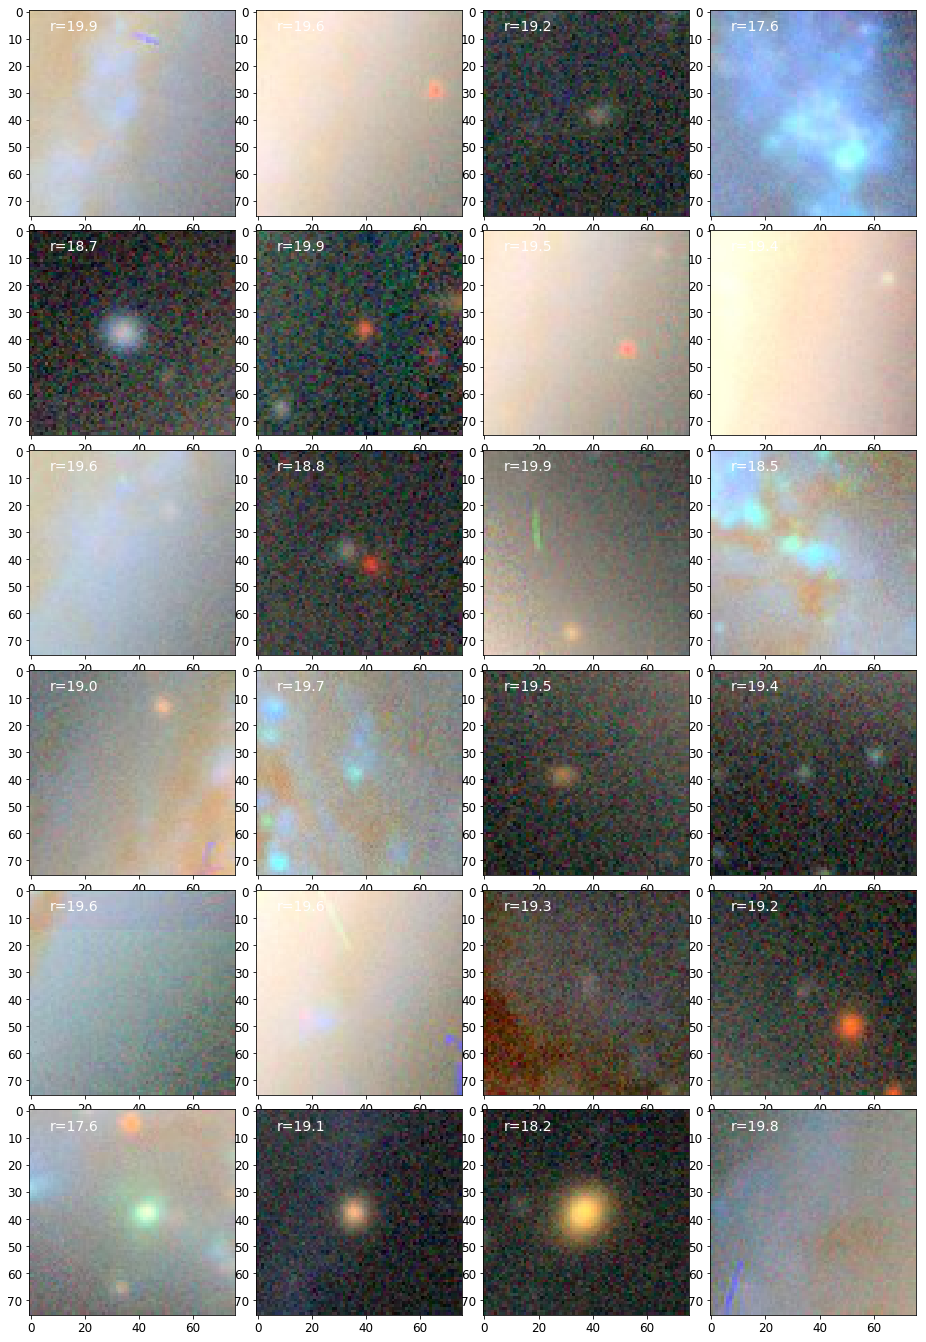

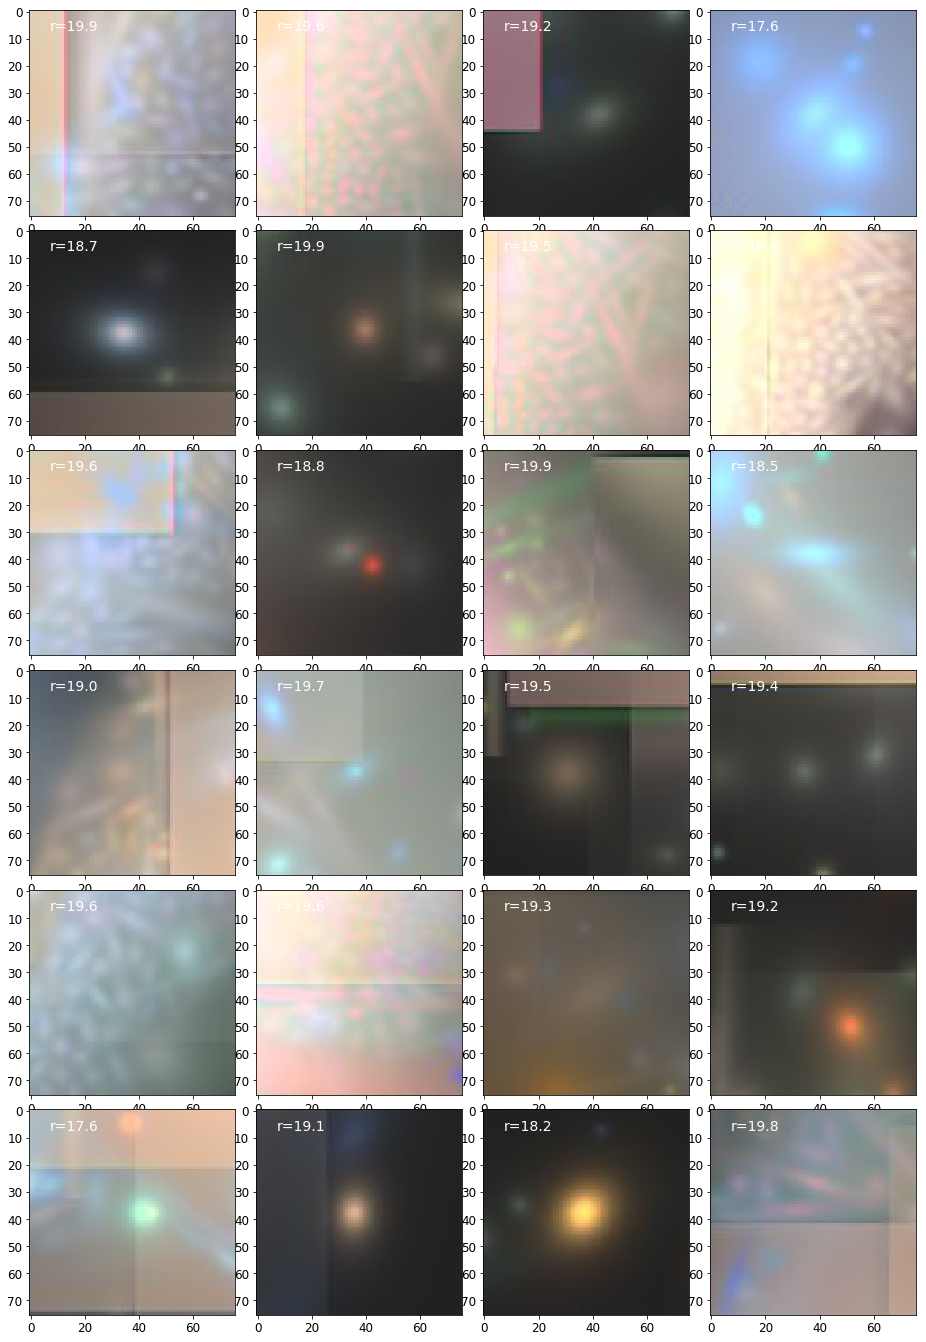

In [29]:
import random
n = 6   #rows
m = 4   #columns
table = (n,m)
RA, DEC, r = extract_annulus(cat[~twomass_mask_cat], twomass_S, 'J_ext', plot2d='circle', mag=(0,10), annulus=(35,80))
#RA, DEC, r = extract_annulus(cat[(twomass_mask_cat) & (~LSLGA_mask_cat)], twomass_S, 'J_ext', plot2d='circle', mag=(0,14), annulus=(5,30))
ranSelect = random.sample(range(len(RA)), n*m)

make_cutout_table(RA[ranSelect], DEC[ranSelect], r[ranSelect], 'r', table, False, boxsize=20, 
                  layer='decals-dr7', layer2=None, savefile=None)

make_cutout_table(RA[ranSelect], DEC[ranSelect], r[ranSelect], 'r', table, False, boxsize=20, 
                  layer='decals-dr7-model', layer2=None, savefile=None)


## Number density 

$\eta_{BQC} = N_{BQC}/A$

$\eta_{AQC} = N_{AQC}/NR_{NOBS}\times \eta_{Ran}$

$\eta_{AQC+TWOMASS} = N_{AQC+TWOMASS}/NR_{NOBS+TWOMASS}\times \eta_{Ran}$

$\eta_{AQC+LSLGA} = N_{AQC+LSLGA}/NR_{NOBS+LSLGA}\times \eta_{Ran}$

$\eta_{R} = NR/A = 13792640/1400$

In [33]:
def n_density(cat, catR, A):
    '''
    Get the cumulative number density
    
    Inputs
    ------
    cat: (ND-array) catalogue
    catR: (ND-array) Random catalogue
    A: (integer) Area of cat and catR in s.q.d
    
    Outputs
    -------
    eta: (2D-array) MAG, Density
    '''
    
    g, r, z, w1, G, rr = get_mag_decals(cat)
    etaR = 13792640./A
    eta = []
    mag = np.linspace(15, 20, 100)
    Nran = len(catR)
    
    for i in range(len(mag)):
        
        N = len(cat[r < mag[i]])
        eta.append([mag[i], etaR*(N/Nran)])
            
    eta = np.array(eta).transpose()
    print('DONE...')
    
    return eta

In [35]:
# get cumulative number density

# BQCs
eta_bqc = n_density(catr, ran, 1400)

# AQCs
mask_nobs = (ran['NOBS_G'] > 0) & (ran['NOBS_R'] > 0) & (ran['NOBS_Z'] > 0)
eta_aqc = n_density(cat, ran[mask_nobs], 1400)

# AQCs + LSLGA veto
eta_LSLGA = n_density(cat[~LSLGA_mask_cat], ran[(mask_nobs) & (~LSLGA_mask_ran)], 1400)

# AQCs + TWOMASS veto
eta_twomass = n_density(cat[~twomass_mask_cat], ran[(mask_nobs) & (~twomass_mask_ran)], 1400)

DONE...
DONE...
DONE...
DONE...


In [9]:
def find_nearest(array, value):
    n = [abs(i-value) for i in array]
    idx = n.index(min(n))
    return idx

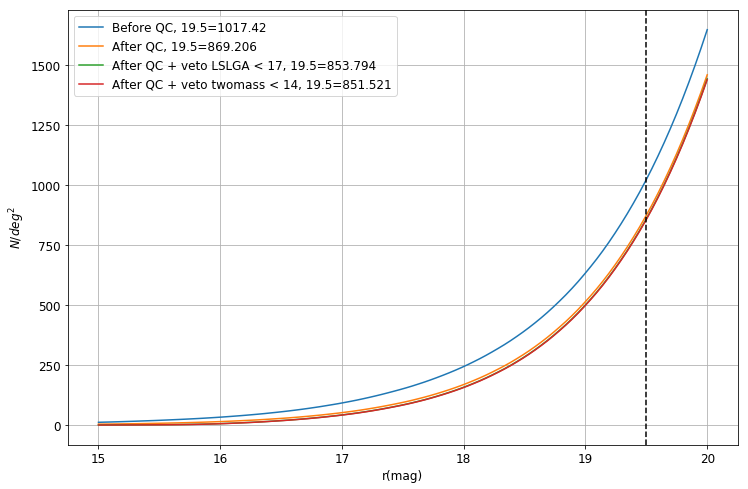

In [41]:
plt.figure(figsize=(12, 8))

plt.plot(eta_bqc[0], eta_bqc[1], label='Before QC, 19.5=%g' %(eta_bqc[1][find_nearest(eta_bqc[0], 19.5)]))
plt.plot(eta_aqc[0], eta_aqc[1], label='After QC, 19.5=%g' %(eta_aqc[1][find_nearest(eta_aqc[0], 19.5)]))

plt.plot(eta_LSLGA[0], eta_LSLGA[1], label='After QC + veto LSLGA < 17, 19.5=%g' 
         %(eta_LSLGA[1][find_nearest(eta_LSLGA[0], 19.5)]))
plt.plot(eta_twomass[0], eta_twomass[1], label='After QC + veto twomass < 14, 19.5=%g' 
         %(eta_twomass[1][find_nearest(eta_twomass[0], 19.5)]))

plt.xlabel(r'r(mag)')
plt.ylabel(r'$N/deg^2$')
plt.axvline(19.5, c='k', ls='--')
plt.legend()
plt.grid()
plt.show()

## 2D density plots

995414 nearby objects ~ 48.943 %


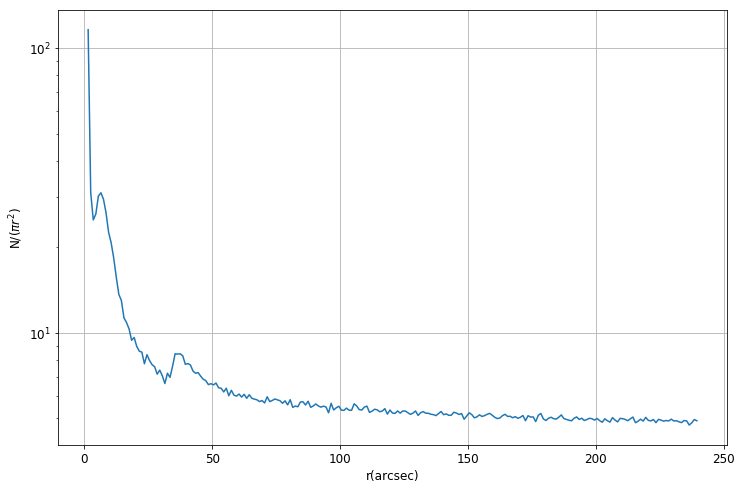

1176956 nearby objects ~ 51.0724 %


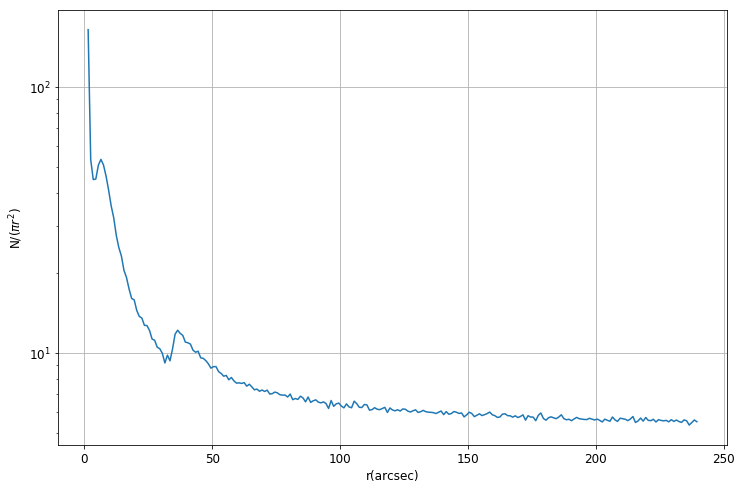

945712 nearby objects ~ 47.1069 %


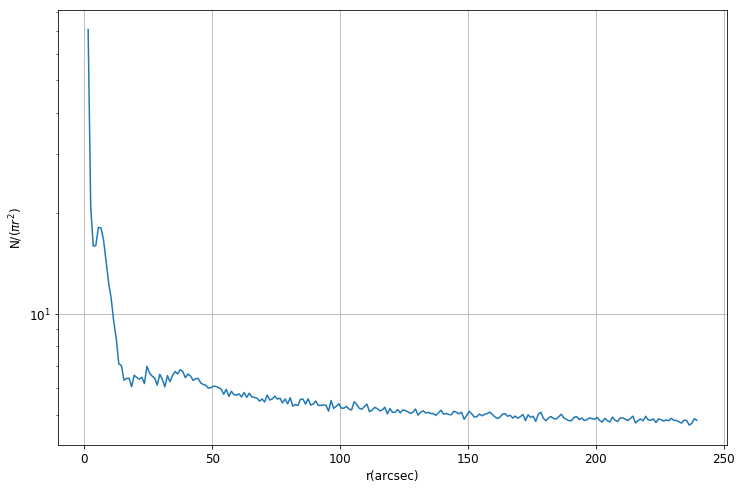

In [45]:
#den_twomass_cat = overdensity(cat, twomass_S, 'J_ext', 35, density=True, magbins=(8,16,5))
#den_twomass_catr = overdensity(catr, twomass_S, 'J_ext', 35, density=True, magbins=(8,16,5))
#den_twomass_cat_twomass = overdensity(cat[~twomass_mask_cat], twomass_S, 'J_ext', 35, density=True, magbins=(8,16,5))
den_LSLGA_cat = overdensity(cat, LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))
den_LSLGA_catr = overdensity(catr, LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))
den_LSLGA_cat_LSLGA = overdensity(cat[~LSLGA_mask_cat], LSLGA_S, 'MAG', 35, density=True, magbins=(12,18,4))

5351097 nearby objects ~ 38.7968 %


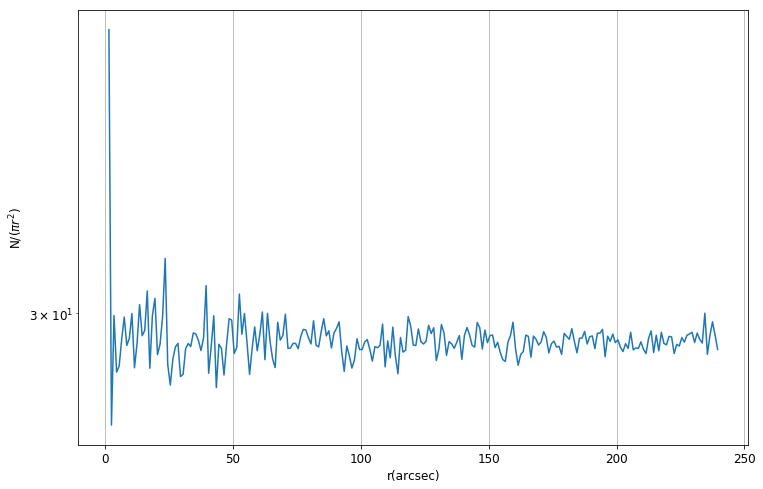

In [46]:
#den_twomass_ran = overdensity(random, twomass_S, 'J_ext', 35, density=True, magbins=(8,16,5))
den_LSLGA_ran = overdensity(random, LSLGA_S, 'J_ext', 35, density=True, magbins=(8,16,5))

4.546556540771277 5.375750190373051 5.658273343258836


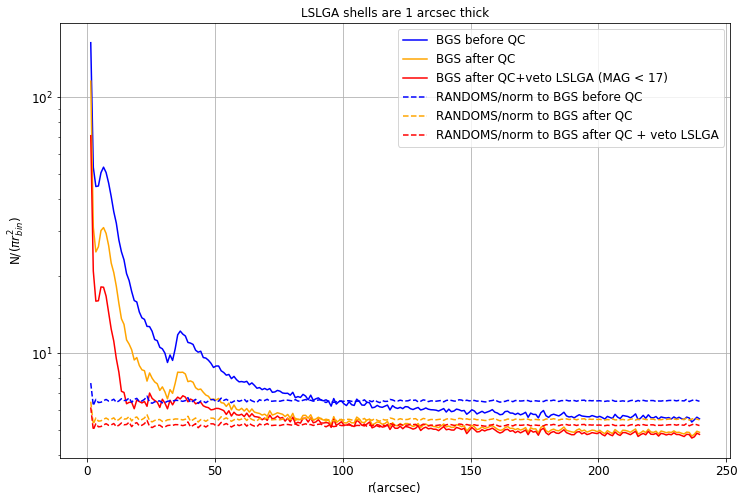

In [49]:
# Nearby to LSLGA Galaxies
del norm1, norm2, norm3
norm1 = 5351097/1176956 # Nrandom nearby/Ncatr nearby 
norm2 = 5351097/995414 # Nrandom nearby/Ncat nearby
norm3 = 5351097/945712 # Nrandom nearby/Ncat+veto LSLGA (MAG < 17) nearby
print(norm1, norm2, norm3)

plt.figure(figsize=(12, 8))
plt.semilogy(den_LSLGA_catr[0], den_LSLGA_catr[1], color='b', label='BGS before QC')
plt.semilogy(den_LSLGA_cat[0], den_LSLGA_cat[1], color='orange', label='BGS after QC')
plt.semilogy(den_LSLGA_cat_LSLGA[0], den_LSLGA_cat_LSLGA[1], color='red', label='BGS after QC+veto LSLGA (MAG < 17)')

plt.semilogy(den_LSLGA_ran[0], den_LSLGA_ran[1]/norm1, color='b', linestyle='--', label='RANDOMS/norm to BGS before QC')
plt.semilogy(den_LSLGA_ran[0], den_LSLGA_ran[1]/norm2, color='orange', linestyle='--', label='RANDOMS/norm to BGS after QC')
plt.semilogy(den_LSLGA_ran[0], den_LSLGA_ran[1]/norm3, color='red', linestyle='--', label='RANDOMS/norm to BGS after QC + veto LSLGA')
#plt.semilogy(test[0], test[1]/norm2, color='orange', linestyle='--', label='RANDOMS norm to BGS after')
plt.xlabel(r'r(arcsec)')
plt.ylabel(r'N/($\pi r_{bin}^2$)')
plt.title(r'LSLGA shells are 1 arcsec thick')
plt.legend()
plt.grid()
plt.show()

4.440112455937165 5.141122903056438 5.390759278056189


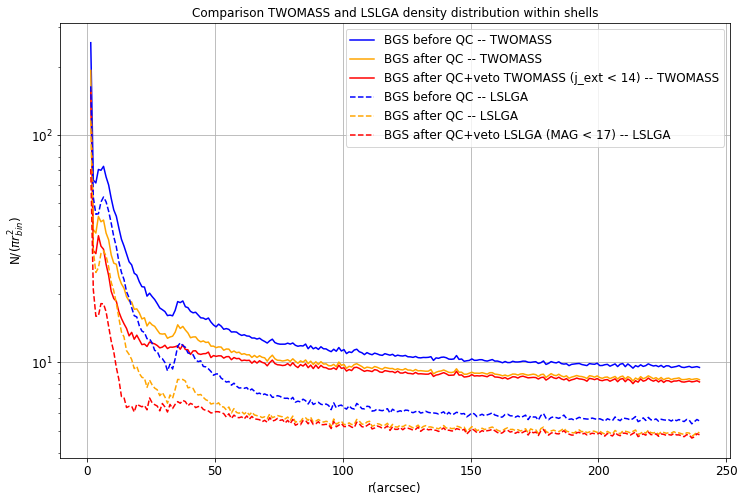

In [52]:
# Nearby to TWOMASS Galaxies
del norm1, norm2, norm3
norm1 = 8959512/2017857 # Nrandom nearby/Ncatr nearby 
norm2 = 8959512/1742715 # Nrandom nearby/Ncat nearby
norm3 = 8959512/1662013 # Nrandom nearby/Ncat+veto TWOMASS (j_ext < 14) nearby
print(norm1, norm2, norm3)

plt.figure(figsize=(12, 8))
plt.semilogy(den_twomass_catr[0], den_twomass_catr[1], color='b', label='BGS before QC -- TWOMASS')
plt.semilogy(den_twomass_cat[0], den_twomass_cat[1], color='orange', label='BGS after QC -- TWOMASS')
plt.semilogy(den_twomass_cat_twomass[0], den_twomass_cat_twomass[1], color='red', label='BGS after QC+veto TWOMASS (j_ext < 14) -- TWOMASS')

plt.semilogy(den_LSLGA_catr[0], den_LSLGA_catr[1], color='b', linestyle='--',label='BGS before QC -- LSLGA')
plt.semilogy(den_LSLGA_cat[0], den_LSLGA_cat[1], color='orange', linestyle='--', label='BGS after QC -- LSLGA')
plt.semilogy(den_LSLGA_cat_LSLGA[0], den_LSLGA_cat_LSLGA[1], color='red', linestyle='--', label='BGS after QC+veto LSLGA (MAG < 17) -- LSLGA')

#plt.semilogy(den_twomass_ran[0], den_twomass_ran[1]/norm1, color='b', linestyle='--', label='RANDOMS/norm to BGS before QC')
#plt.semilogy(den_twomass_ran[0], den_twomass_ran[1]/norm2, color='orange', linestyle='--', label='RANDOMS/norm to BGS after QC')
#plt.semilogy(den_twomass_ran[0], den_twomass_ran[1]/norm3, color='red', linestyle='--', label='RANDOMS/norm to BGS after QC + veto TWOMASS')

plt.xlabel(r'r(arcsec)')
plt.ylabel(r'N/($\pi r_{bin}^2$)')
plt.title(r'Comparison TWOMASS and LSLGA density distribution within shells')
plt.legend()
plt.grid()
plt.show()

## fiberflux

In [22]:
def fiberflux(cat, col1, col2, title):
    
    mag1 = flux_to_mag(cat[col1]/cat['MW_TRANSMISSION_R'])
    mag2 = flux_to_mag(cat[col2])
    
    fig = plt.figure(figsize=(8, 8))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    axScatter2 = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    

    #axScatter.plot(d_ra, d_dec, 'k.', markersize=markersize, alpha=alpha)
    pos = axScatter.hexbin(mag1, mag2, gridsize=(60,60), cmap='viridis', bins='log', mincnt=1,label=r'test', alpha=0.8)
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    fig.colorbar(pos, cax=cbaxes, label=r'$\log_{10}(N)$')
    #axScatter.scatter(mag1, mag2, s=0.1)
    axScatter.set_ylabel(r'$22.5 - 2.5\times \log_{10}$(%s)' %(col2))
    #axScatter.set_xlabel(r'$22.5 - 2.5\times \log_{10}$(%s)' %(col1))
    axScatter.set_xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %(col1, 'MW_TRANSMISSION_R'))
    axScatter.grid()

    weights1 = np.zeros_like(mag1) + 1/1400.
    
    N1 = axHistx.hist(mag1, bins=300, cumulative=True, histtype='step', weights=weights1, color='r', linewidth=2)
    N2 = axHisty.hist(mag2, bins=300, cumulative=True, histtype='step', weights=weights1, color='r', linewidth=2, orientation='horizontal')
    
    axScatter.axhline(N2[1][find_nearest(N2[0], 800)], color='black', linestyle='--', linewidth=1.5, label=r'$800/deg^2$')
    axScatter.axvline(N1[1][find_nearest(N1[0], 800)], color='black', linestyle='--', linewidth=1.5)
    print('800 p.s.q.d: x = %2.4g, y = %2.4g' %(N1[1][find_nearest(N1[0], 800)], N2[1][find_nearest(N2[0], 800)] ))
    
    axScatter.axhline(N2[1][find_nearest(N2[0], 1400)], color='orange', linestyle='--', linewidth=1.5, label=r'$1400/deg^2$')
    axScatter.axvline(N1[1][find_nearest(N1[0], 1400)], color='orange', linestyle='--', linewidth=1.5)
    print('1400 p.s.q.d: x = %2.4g, y = %2.4g' %(N1[1][find_nearest(N1[0], 1400)], N2[1][find_nearest(N2[0], 1400)] ))
    
    axHistx.axis('off')
    axHisty.axis('off')
    
    print('---------------------')
    print('In rmag=19.5: %2.4g, %2.4g' %(N1[0][find_nearest(N1[1], 19.5)-1], N1[1][find_nearest(N1[1], 19.5)-1]))
    print('In rmag=20: %2.4g' %(N1[0][find_nearest(N1[1], 19.9)]))
    #print('In rmag=20.1: %2.4g' %(N1[0][find_nearest(N1[1], 20.1)]))
    #print('In rmag=20.2: %2.4g' %(N1[0][find_nearest(N1[1], 20.2)]))
    #print('In rmag=20.5: %2.4g' %(N1[0][find_nearest(N1[1], 20.5)]))
    
    #print(len(mag1[mag1 < 19.39]), len(mag2[mag2 < 20.7]))
    
    #lgnd = axScatter.legend()
    #for handle in lgnd.legendHandles:
    #    handle.set_sizes([10.0])

800 p.s.q.d: x = 19.37, y = 20.72
1400 p.s.q.d: x = 19.93, y = 21.81
---------------------
In rmag=19.5: 886, 19.48
In rmag=20: 1348


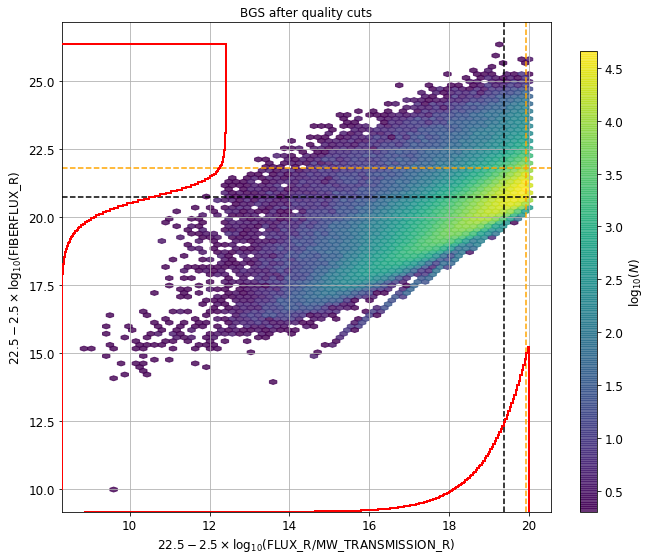

In [23]:
fiberflux(cat, 'FLUX_R', 'FIBERFLUX_R', 'BGS after quality cuts')

## DEV ZONE

Number Pixels 196608
Pixel area: 0.209823411303
2033821 2033821 797
1433.51354602


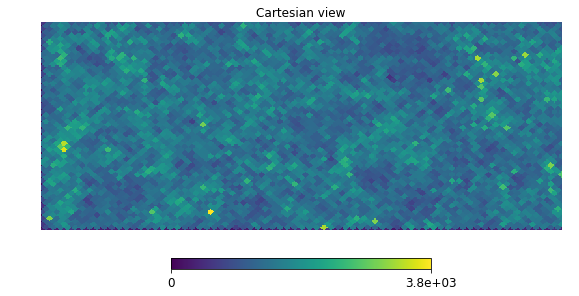

In [19]:
def pixmap(cat, N):
    #theta = 0.5 * np.pi - np.deg2rad(dec)
    #phi = np.deg2rad(ra)
    #N = 512
    ra = cat['RA']
    dec = cat['DEC']
    mask = ra > 180
    ra[mask] = ra[mask] - 360.
    mask = ra < -180
    ra[mask] = ra[mask] + 360.
    
    m = hp.ang2pix(N, ra, dec, nest=False, lonlat=True)

    def gen_fast_map(ip_, nside=N):
        npixel  = hp.nside2npix(nside)
        print('Number Pixels',npixel)
        #pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True)
        #print('Pixel area:', pix_area)
        map_ = np.bincount(ip_,minlength=npixel)
        return map_
    
    map = gen_fast_map(m)
    
    pix_area = hp.pixelfunc.nside2pixarea(N, degrees=True)
    print('Pixel area:', pix_area)
    print(map.sum(), len(ra), map.max())
    print(len(map[map>0])*pix_area)
    hp.cartview(map/pix_area, lonra=[-180, -130], latra=[-2,18])

pixmap(cat, 128)

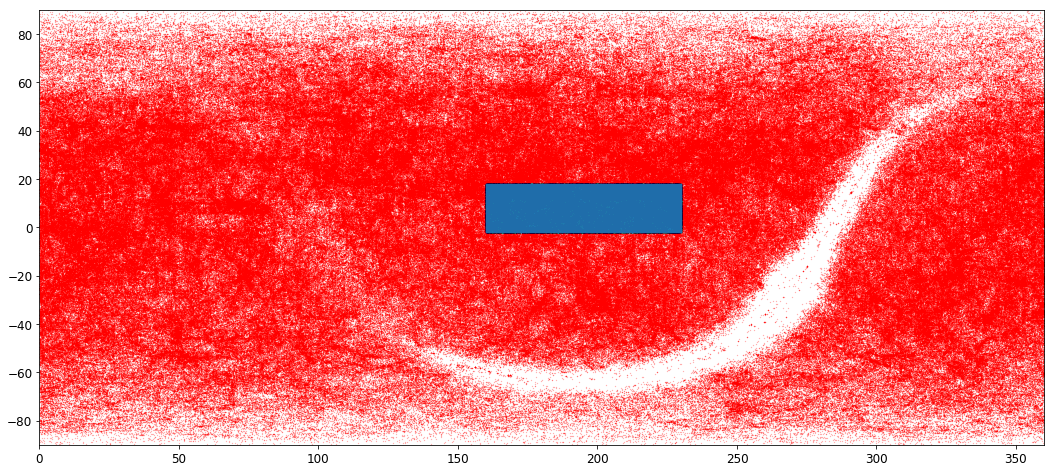

In [5]:
plt.figure(figsize=(18, 8))
plt.plot(twomass['RA'], twomass['DEC'], '.', color='red', markersize=0.5, alpha=0.5)
plt.plot(catr['RA'], catr['DEC'], '.', markersize=0.4, alpha=0.2)
#plt.plot(tycho['RA'], tycho['DEC'], '.', markersize=0.3, alpha=0.2)
plt.axis([0, 360, -90, 90])
#plt.axis([200, 230, -2, 5])
plt.show()

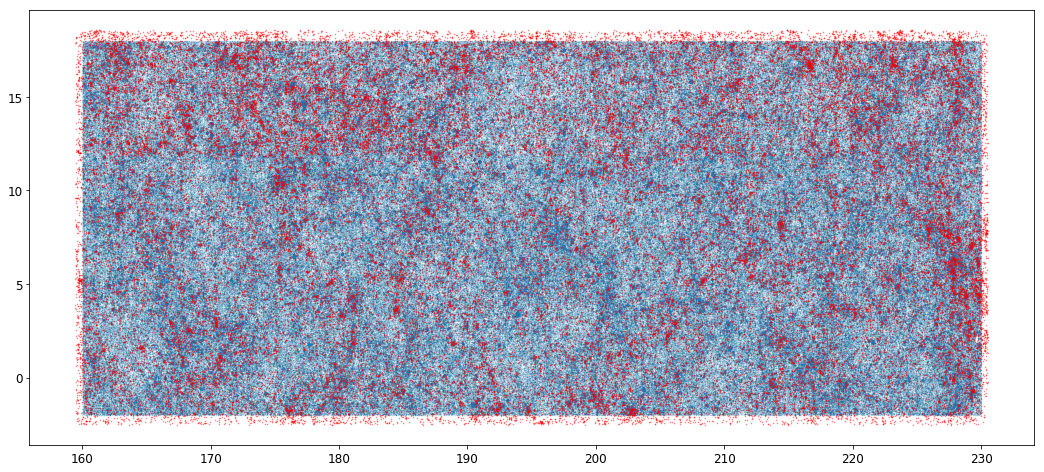

In [9]:
plt.figure(figsize=(18, 8))
plt.plot(catr['RA'], catr['DEC'], '.', markersize=0.4, alpha=0.2)
plt.plot(twomass_S['RA'], twomass_S['DEC'], '.', color='red', markersize=1, alpha=0.5)
#plt.plot(tycho['RA'], tycho['DEC'], '.', markersize=0.3, alpha=0.2)
#plt.axis([0, 360, -90, 90])
#plt.axis([200, 230, -2, 5])
plt.show()

#overdensity(cat, twomass_S, 'J_ext', magbins=(6,16,11))

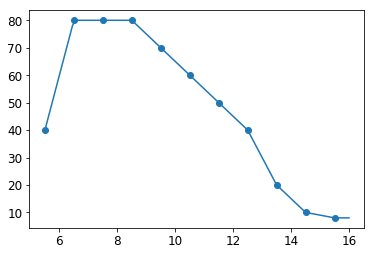

In [14]:
x, y = np.transpose([[5.5,40], [6.5, 80], [7.5, 80], [8.5, 80], [9.5, 70], [10.5, 60], [11.5, 50], [12.5, 40], [13.5, 20], [14.5, 10], [15.5, 8]])
circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))
X = np.linspace(5.5, 16, 100)
plt.scatter(x, y)
plt.plot(X, circular_mask_radii_func(X))

5.985126401288617 6.781639092132494


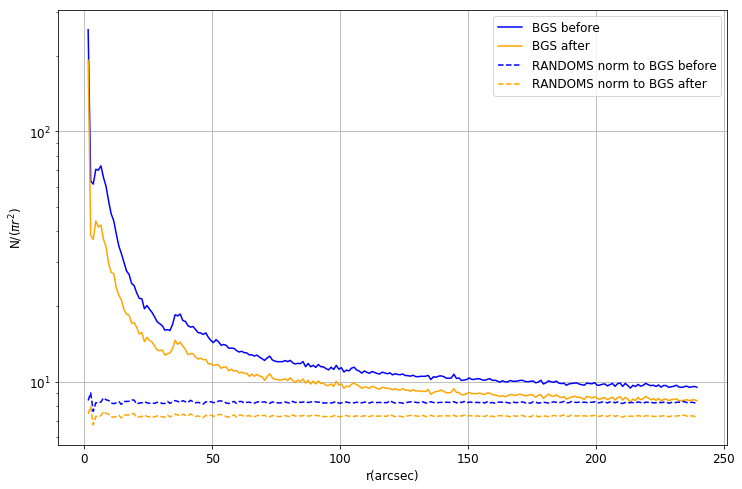

In [210]:
norm1 = len(random_S)/len(catr)
norm2 = len(random_S)/len(cat)
print(norm1, norm2)

plt.figure(figsize=(12, 8))
plt.semilogy(density_catr[0], density_catr[1], color='b', label='BGS before')
plt.semilogy(density_cat[0], density_cat[1], color='orange', label='BGS after')
plt.semilogy(test[0], test[1]/norm1, color='b', linestyle='--', label='RANDOMS norm to BGS before')
plt.semilogy(test[0], test[1]/norm2, color='orange', linestyle='--', label='RANDOMS norm to BGS after')
plt.xlabel(r'r(arcsec)')
plt.ylabel(r'N/($\pi r^2$)')
plt.legend()
plt.grid()
plt.show()

In [36]:
#extract subcatalogue and save it
del cat_lite

cat_lite = Table()
lite_names = ('RA', 'DEC', 'TYPE', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FLUX_W1','MW_TRANSMISSION_R',
              'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'GAIA_PHOT_G_MEAN_MAG', 'Grr', 
              'BRIGHTSTARINBLOB')
for i in lite_names:
    
    cat_lite[i] = catr[i]
    
cat_lite.write('caseC/catr_lite.fits', overwrite=True)